<a href="https://colab.research.google.com/github/Komal-Zia/Assignment002/blob/main/Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyemd tensorflow scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 7.2 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
PyEMD successfully imported!
Please upload your dataset CSV file.


Saving IMF2.csv to IMF2 (1).csv
Dataset loaded successfully!


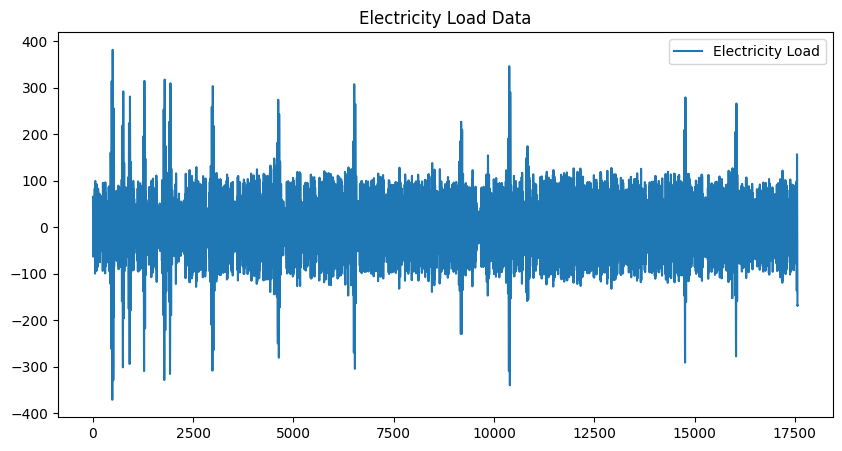

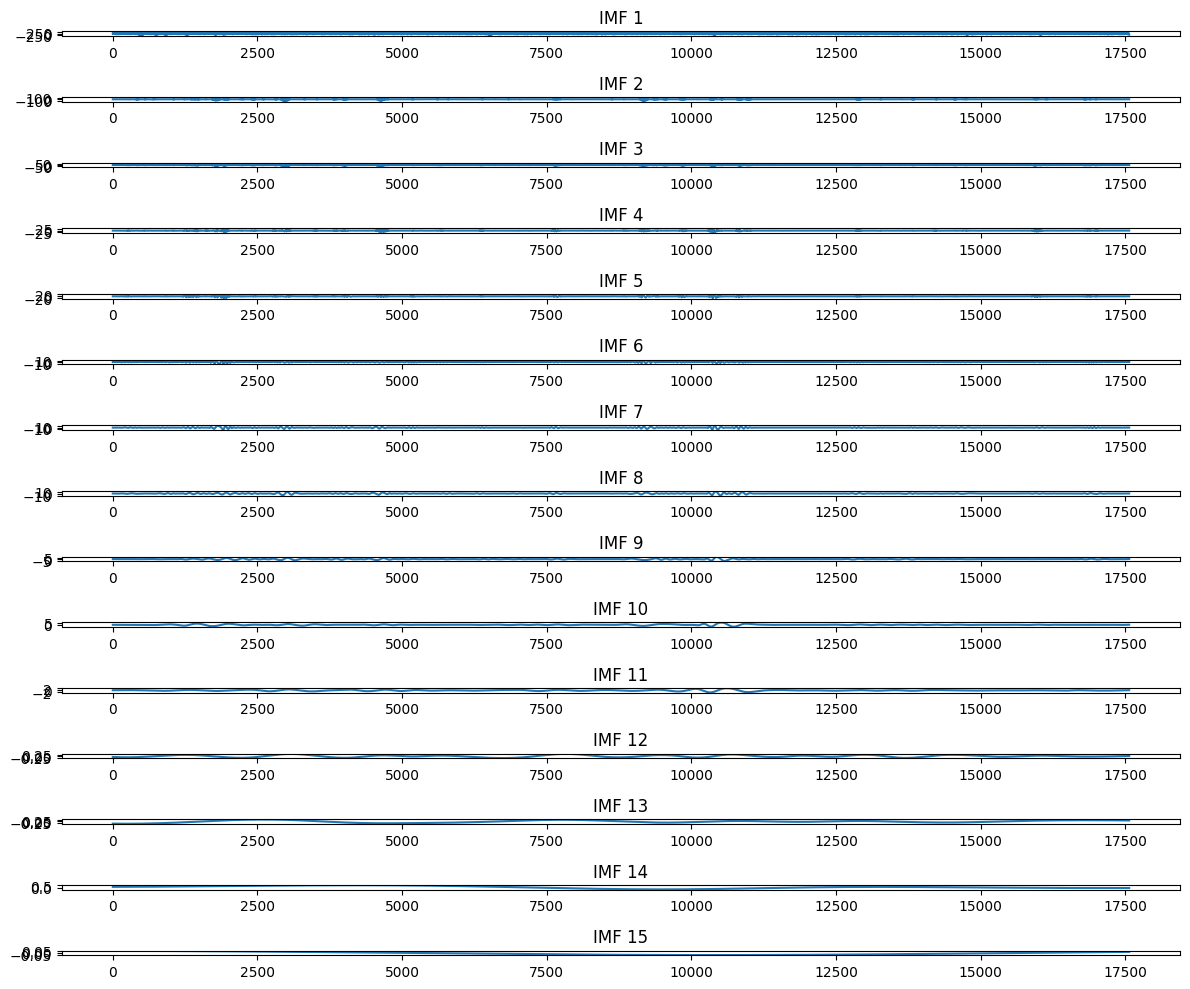

In [3]:
!pip install EMD-signal
from PyEMD import CEEMDAN
print("PyEMD successfully imported!")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the dataset
def load_and_decompose(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    print("Dataset loaded successfully!")

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data.iloc[:, 1], label='Electricity Load')
    plt.title("Electricity Load Data")
    plt.legend()
    plt.show()

    # Decompose using CEEMDAN
    ceemdan = CEEMDAN()
    load_series = data.iloc[:, 1].values  # Assuming the load column is the second column
    IMFs = ceemdan(load_series)

    # Plot IMFs
    plt.figure(figsize=(12, 10))
    for i, imf in enumerate(IMFs):
        plt.subplot(len(IMFs), 1, i + 1)
        plt.plot(imf)
        plt.title(f"IMF {i + 1}")
    plt.tight_layout()
    plt.show()

    return IMFs

# Call the function for data upload in Colab
from google.colab import files
print("Please upload your dataset CSV file.")
uploaded = files.upload()
dataset_path = list(uploaded.keys())[0]

IMFs = load_and_decompose(dataset_path)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
import tensorflow as tf

# Define the CLDNM model
def create_cldnm(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=False)(input_layer)

    # Dendritic Layer
    def dendritic_layer(x):
        nonlinear_transform = tf.nn.relu(x)
        dendritic_product = tf.reduce_prod(nonlinear_transform, axis=-1, keepdims=True)
        return dendritic_product

    dendritic_out = Lambda(dendritic_layer)(lstm_out)

    # Dense Output Layer
    output_layer = Dense(1, activation='linear')(dendritic_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    return model



In [7]:
from sklearn.model_selection import train_test_split

# Prepare the dataset for training
def prepare_dataset(IMFs, time_steps=10):
    scaler = MinMaxScaler()
    X, y = [], []

    for imf in IMFs:
        scaled_imf = scaler.fit_transform(imf.reshape(-1, 1))
        for i in range(len(scaled_imf) - time_steps):
            X.append(scaled_imf[i:i+time_steps])
            y.append(scaled_imf[i+time_steps])

    return np.array(X), np.array(y)

X, y = prepare_dataset(IMFs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
from tensorflow.keras.optimizers import Adam

model = create_cldnm(input_shape=(X.shape[1], X.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,898 (66.01 KB)

 Trainable params: 16,898 (66.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0551 - mae: 0.1627 - val_loss: 0.0266 - val_mae: 0.1004
Epoch 2/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0260 - mae: 0.0989 - val_loss: 0.0267 - val_mae: 0.1017
Epoch 3/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.0262 - mae: 0.0997 - val_loss: 0.0267 - val_mae: 0.1017
Epoch 4/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.0262 - mae: 0.0996 - val_loss: 0.0266 - val_mae: 0.1001
Epoch 5/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0262 - mae: 0.0995 - val_loss: 0.0266 - val_mae: 0.1001
Epoch 6/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0262 - mae: 0.0996 - val_loss: 0.0267 - val_mae: 0.1017
Epoch 7/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 0.0261 - mae: 0.0993 - val_loss: 0.0266 - val_mae: 0.1003
Epoch 8/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0262 - mae: 0.0995 - val_loss: 0.0266 - val_mae: 0.1006
Epoch 9/50
6584/6584 ━━━━━━━━━━━

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Metrics calculation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model Evaluation:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}%\nR^2: {r2}")




1646/1646 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Model Evaluation:
MAE: 0.10207833448887234
RMSE: 0.16335447172583398
MAPE: inf%
R^2: -0.0032680865023808625


<ipython-input-9-ecb320f67ed1>:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
